In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np
import pandas as pd 

csv_directory = '/Users/aimee/Documents/College/Courses/S24/17-735/17735-project/ExtractedData'



In [2]:
def dtt2timestamp(dtt):
  time_in_sec = (dtt.hour*60 + dtt.minute) * 60 + dtt.second
  return time_in_sec

In [3]:
# Lists to hold data from each file
logon_data = []
logoff_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Extract time and hour from Timestamp
        df['Time'] = df['Timestamp'].dt.time
        df['Hour'] = df['Timestamp'].dt.hour

        # Append DataFrame to the list by action
        logon_data.append(df[df['Action'] == 'Logon'])
        logoff_data.append(df[df['Action'] == 'Logoff'])

# Concatenate all logon and logoff data into two separate DataFrames
logon_df = pd.concat(logon_data)
logoff_df = pd.concat(logoff_data)

# Split the data so that 80% is used for model training, 20% for testing
logon_train_df, logon_test_df = train_test_split(logon_df, test_size=0.2)
logoff_train_df, logoff_test_df = train_test_split(logoff_df, test_size=0.2)


In [4]:
# Creating training data

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_train_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_train_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_train_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_train_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_train_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_train_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']

In [5]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np
import pandas as pd 

df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats_array)


#logon/logoff model training
forest = IsolationForest(bootstrap=False, contamination= 0.1 , max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)
forest.fit(log_stats_array)

log_ascore = forest.decision_function(log_stats_array)
log_ascore[:10]
print(log_ascore[:10])

[[27301 49617 28461 ... 49617 28461 32400]
 [28203 29393 29167 ... 29393 29167 25200]
 [28203 29398 28993 ... 29398 28993 25200]
 ...
 [23700 59713 24294 ... 59713 24294 28800]
 [30005 31186 30335 ... 31186 30335 28800]
 [32706 33891 32954 ... 33891 32954 32400]]
[0.1662071  0.18186057 0.19181749 0.15531865 0.15439209 0.15084396
 0.17964888 0.17154208 0.15541223 0.17892665]


In [6]:
# Creating testing data

# Group by 'User' and aggregate times for logon
df_user_logon_stats = logon_test_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logon_mode = logon_test_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logon_mean = logon_test_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logon_mean['Hour'] = df_logon_mean['Hour'].astype(int)
df_logon_mean['Hour'] = pd.to_datetime(df_logon_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logon stats DataFrame
df_user_logon_stats['mode'] = df_logon_mode['Time']
df_user_logon_stats['mean'] = df_logon_mean['Hour']

# Group by 'User' and aggregate times for logoff
df_user_logoff_stats = logoff_test_df.groupby('User')['Time'].agg(['min', 'max']).reset_index()
df_logoff_mode = logoff_test_df.groupby('User')['Time'].agg(lambda x: x.value_counts().index[0]).reset_index()
df_logoff_mean = logoff_test_df.groupby('User')['Hour'].mean().reset_index()

# Convert mean hour to int and then to time
df_logoff_mean['Hour'] = df_logoff_mean['Hour'].astype(int)
df_logoff_mean['Hour'] = pd.to_datetime(df_logoff_mean['Hour'], format='%H').dt.time

# Add mode and mean to the logoff stats DataFrame
df_user_logoff_stats['mode'] = df_logoff_mode['Time']
df_user_logoff_stats['mean'] = df_logoff_mean['Hour']

In [7]:
df_user_logon_stats_sec = df_user_logon_stats

time_columns = ['min', 'max', 'mode', 'mean']
for col in time_columns:
    df_user_logon_stats_sec[col] = pd.to_datetime(df_user_logon_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['min']]
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logon_stats_sec['mean']]

df_user_logon_stats_sec['min_ts'] = min_ts
df_user_logon_stats_sec['max_ts'] = max_ts
df_user_logon_stats_sec['mode_ts'] = mode_ts
df_user_logon_stats_sec['mean_ts'] = mean_ts


df_user_logon_stats_sec.drop(['min','max','mode','mean'], axis=1)

df_user_logoff_stats_sec = df_user_logoff_stats

for col in time_columns:
    df_user_logoff_stats_sec[col] = pd.to_datetime(df_user_logoff_stats[col], format='%H:%M:%S').dt.time


min_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['min']] 
max_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['max']]
mode_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mode']]
mean_ts = [dtt2timestamp(dtt) for dtt in df_user_logoff_stats_sec['mean']]


df_user_logoff_stats_sec['min_ts'] = min_ts
df_user_logoff_stats_sec['max_ts'] = max_ts
df_user_logoff_stats_sec['mode_ts'] = mode_ts
df_user_logoff_stats_sec['mean_ts'] = mean_ts


df_user_logoff_stats_sec.drop(['min', 'max','mode','mean'], axis=1)


df_log_on_off_stats = pd.DataFrame()

df_log_on_off_stats['User'] = df_user_logon_stats_sec['User']
df_log_on_off_stats['on_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['on_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['on_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['on_mean_ts'] = df_user_logon_stats_sec['mean_ts']
df_log_on_off_stats['off_min_ts'] = df_user_logon_stats_sec['min_ts']
df_log_on_off_stats['off_max_ts'] = df_user_logon_stats_sec['max_ts']
df_log_on_off_stats['off_mode_ts'] = df_user_logon_stats_sec['mode_ts']
df_log_on_off_stats['off_mean_ts'] = df_user_logon_stats_sec['mean_ts']


log_stats = df_log_on_off_stats.drop(['User'], axis=1)
log_stats_array = np.array(log_stats)  # Changed from np.matrix to np.array
print(log_stats_array)

[[27311 49426 27683 ... 49426 27683 28800]
 [28207 29386 29386 ... 29386 29386 25200]
 [28238 29391 28333 ... 29391 28333 25200]
 ...
 [23722 55810 24716 ... 55810 24716 28800]
 [30006 31165 30359 ... 31165 30359 28800]
 [32702 33894 33836 ... 33894 33836 32400]]


In [8]:
df_log_on_off_stats

,User,on_min_ts,on_max_ts,on_mode_ts,on_mean_ts,off_min_ts,off_max_ts,off_mode_ts,off_mean_ts
0,DTAA/AAA0371,27311,49426,27683,28800,27311,49426,27683,28800
1,DTAA/AAC0344,28207,29386,29386,25200,28207,29386,29386,25200
2,DTAA/AAC0599,28238,29391,28333,25200,28238,29391,28333,25200
3,DTAA/AAH0734,30005,31179,30359,28800,30005,31179,30359,28800
4,DTAA/AAK0658,30024,31191,30359,28800,30024,31191,30359,28800
...,...,...,...,...,...,...,...,...,...
995,DTAA/ZGH0528,30948,53288,31839,36000,30948,53288,31839,36000
996,DTAA/ZKE0662,26429,48377,27550,32400,26429,48377,27550,32400
997,DTAA/ZKH0388,23722,55810,24716,28800,23722,55810,24716,28800
998,DTAA/ZKN0548,30006,31165,30359,28800,30006,31165,30359,28800


In [9]:
log_ascore = forest.decision_function(log_stats_array)
log_ascore[:10]

# counting the values
df22 = pd.Series(forest.predict(log_stats_array))
df22 = df22.map({1:0, -1:1})
print(df22.value_counts())


df_user_log_result = pd.DataFrame()
df_user_log_result['User'] = df_user_logoff_stats_sec['User']
df_user_log_result['anomaly_score'] = log_ascore
print(df_user_log_result)


outliers = df_user_log_result.loc[df_user_log_result['anomaly_score'] < 0]
print(outliers)

0    844
1    156
dtype: int64
             User  anomaly_score
0    DTAA/AAA0371       0.113410
1    DTAA/AAC0344       0.164057
2    DTAA/AAC0599       0.169984
3    DTAA/AAH0734       0.153489
4    DTAA/AAK0658       0.147806
..            ...            ...
995  DTAA/ZGH0528       0.076114
996  DTAA/ZKE0662       0.144301
997  DTAA/ZKH0388       0.024735
998  DTAA/ZKN0548       0.152805
999  DTAA/ZRR0705       0.032223

[1000 rows x 2 columns]
             User  anomaly_score
13   DTAA/ABS0726      -0.024224
14   DTAA/ACD0647      -0.035747
24   DTAA/AFF0760      -0.031365
26   DTAA/AFH0331      -0.041999
28   DTAA/AFO0022      -0.144349
..            ...            ...
947  DTAA/VNM0127      -0.019739
954  DTAA/WCN0570      -0.056711
970  DTAA/WTA0867      -0.040458
972  DTAA/XCB0445      -0.053485
990  DTAA/ZAB0889      -0.022208

[156 rows x 2 columns]


array([[<AxesSubplot:title={'center':'min_ts'}>,
        <AxesSubplot:title={'center':'max_ts'}>],
       [<AxesSubplot:title={'center':'mode_ts'}>,
        <AxesSubplot:title={'center':'mean_ts'}>]], dtype=object)

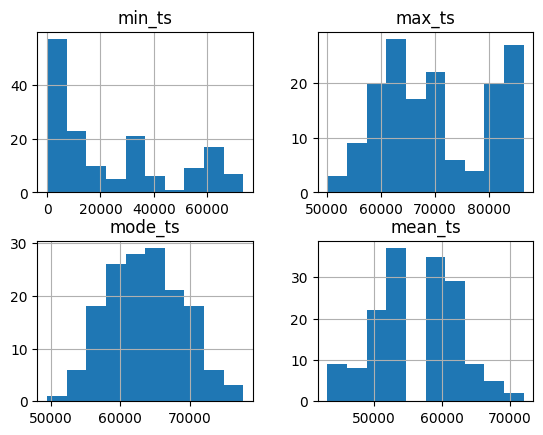

In [10]:
df_user_logoff_stats_sec.loc[df_user_log_result['anomaly_score'] < 0].hist()

In [11]:
# Lists to hold data from each file
connect_data = []
disconnect_data = []

# Iterate over each CSV file in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Full path to the CSV file
        csv_path = os.path.join(csv_directory, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path, names=['User', 'Timestamp', 'PC', 'ActivityType', 'Action'])

        # Convert Timestamp to datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Filter DataFrame by action and append to the respective list
        connect_data.append(df[df['Action'] == 'Connect'])
        disconnect_data.append(df[df['Action'] == 'Disconnect'])

# Concatenate all connect and disconnect data into two separate DataFrames
connect_df = pd.concat(connect_data)
disconnect_df = pd.concat(disconnect_data)

# Split the data so that 80% is used for model training, 20% for testing
connect_train_df, connect_test_df = train_test_split(connect_df, test_size=0.2)
disconnect_train_df, disconnect_test_df = train_test_split(disconnect_df, test_size=0.2)

In [12]:
# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_train_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_train_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_train_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)


# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values

In [13]:
# Training model
# Set up and train IsolationForest model
forest = IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
                         max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
                         verbose=0)
forest.fit(device_full_array)

IsolationForest(contamination=0.1, n_jobs=1)

In [14]:
# Function to format datetime as H:M:S
format_time = lambda x: x.strftime('%H:%M:%S')

# Calculate means for connect and disconnect
connect_means = connect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))
disconnect_means = disconnect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.mean()))

# Calculate modes for connect and disconnect
# We use scipy's mode function which returns the first mode in case of multimodal data
connect_modes = connect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))
disconnect_modes = disconnect_test_df.groupby('User')['Timestamp'].apply(lambda x: format_time(x.dt.time.mode()[0]))

# Convert Series to DataFrame for CSV output
connect_means_df = connect_means.reset_index().rename(columns={'Timestamp': 'Connect_mean_time'})
connect_modes_df = connect_modes.reset_index().rename(columns={'Timestamp': 'Connect_mode_time'})

disconnect_means_df = disconnect_means.reset_index().rename(columns={'Timestamp': 'Disconnect_mean_time'})
disconnect_modes_df = disconnect_modes.reset_index().rename(columns={'Timestamp': 'Disconnect_mode_time'})

# Create stats DataFrame for connection data
df_device_conn_stats = connect_test_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time.apply(format_time)
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_test_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time.apply(format_time)
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time.apply(format_time)

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time'}, inplace=True)

# These variables hold the respective statistics for later use in your code:
# connect_means_df, connect_modes_df, disconnect_means_df, disconnect_modes_df

# Create stats DataFrame for connection data
df_device_conn_stats = connect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_conn_stats['min'] = df_device_conn_stats['min'].dt.time
df_device_conn_stats['max'] = df_device_conn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_means_df, on='User', how='left')
df_device_conn_stats = pd.merge(df_device_conn_stats, connect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_conn_stats.rename(columns={'min': 'Connect_min_time',
                                     'max': 'Connect_max_time',
                                     'Connect_mean_time': 'Connect_mean_time',
                                     'Connect_mode_time': 'Connect_mode_time'}, inplace=True)

# Create stats DataFrame for disconnection data
df_device_disconn_stats = disconnect_df.groupby('User')['Timestamp'].agg(['min', 'max']).reset_index()
df_device_disconn_stats['min'] = df_device_disconn_stats['min'].dt.time
df_device_disconn_stats['max'] = df_device_disconn_stats['max'].dt.time

# Merge the mean and mode dataframes with the stats DataFrames
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_means_df, on='User', how='left')
df_device_disconn_stats = pd.merge(df_device_disconn_stats, disconnect_modes_df, on='User', how='left')

# Rename the columns for consistency and clarity
df_device_disconn_stats.rename(columns={'min': 'Disconnect_min_time',
                                        'max': 'Disconnect_max_time',
                                        'Disconnect_mean_time': 'Disconnect_mean_time',
                                        'Disconnect_mode_time': 'Disconnect_mode_time'}, inplace=True)

# Conversion of connection times to timestamps in seconds
for col in ['Connect_min_time', 'Connect_max_time', 'Connect_mode_time', 'Connect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_conn_stats[col + '_ts'] = pd.to_datetime(df_device_conn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_conn_stats[col + '_sec'] = df_device_conn_stats[col + '_ts'].apply(dtt2timestamp)

# Conversion of disconnection times to timestamps in seconds
for col in ['Disconnect_min_time', 'Disconnect_max_time', 'Disconnect_mode_time', 'Disconnect_mean_time']:
    # Convert the time strings to datetime.time objects
    df_device_disconn_stats[col + '_ts'] = pd.to_datetime(df_device_disconn_stats[col], format='%H:%M:%S').dt.time
    # Apply the dtt2timestamp function to convert to seconds
    df_device_disconn_stats[col + '_sec'] = df_device_disconn_stats[col + '_ts'].apply(dtt2timestamp)

# Merge the connection and disconnection dataframes
df_device_full = pd.merge(df_device_conn_stats, df_device_disconn_stats, on='User')
df_device_full = df_device_full.dropna()

# Select columns that end with '_sec' for analysis
sec_columns = [col for col in df_device_full.columns if col.endswith('_sec')]
device_full_array = df_device_full[sec_columns].values



In [15]:
# Calculate anomaly scores
df_device_full['anomaly_score'] = forest.decision_function(device_full_array)

# Identifying outliers
df_device_full_outliers = df_device_full[df_device_full['anomaly_score'] < 0]
print(df_device_full_outliers)

             User Connect_min_time Connect_max_time Connect_mean_time  \
21   DTAA/ASO0023         02:50:58         04:50:57          16:16:59   
28   DTAA/BIR0534         02:31:52         03:27:26          05:29:11   
42   DTAA/CHS0324         23:51:28         04:33:36          05:35:57   
44   DTAA/CLK0383         00:33:15         20:47:02          01:55:30   
46   DTAA/CMF0339         03:00:27         05:03:03          21:36:11   
47   DTAA/COS0121         13:23:56         00:10:59          20:30:55   
51   DTAA/CTR0537         00:54:40         21:55:26          09:19:28   
61   DTAA/DFZ0063         23:22:27         21:57:51          01:45:29   
89   DTAA/HAG0649         00:48:14         04:38:32          17:26:02   
98   DTAA/HNS0858         21:45:26         23:33:49          16:45:09   
107  DTAA/JAH0544         03:29:41         23:07:03          22:38:00   
109  DTAA/JBL0450         00:36:02         00:13:17          23:42:51   
114  DTAA/JGC0775         17:29:35         03:11:06

In [16]:
df_all = pd.DataFrame()

# Read all CSV files and concatenate into a single DataFrame
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_directory, filename)
        df_temp = pd.read_csv(file_path, header=None)  # Assuming the CSV has no header
        df_temp.columns = ['User', 'Timestamp', 'PC', 'Activity', 'Action']  # Assign column names
        df_all = pd.concat([df_all, df_temp])

# Ensure 'Timestamp' is a datetime object
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%m/%d/%Y %H:%M:%S')

# Split the data so that 80% is used for model training, 20% for testing
df_train_all, df_test_all = train_test_split(df_all, test_size=0.2)


In [17]:
# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_train_all[df_train_all['Action'] == 'Logon']
df_logoff = df_train_all[df_train_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [18]:
# Train model 
# Let's assume df_user_pc_logon and df_user_pc_logoff are obtained from the previous code
# We will use df_user_pc_logon for this example

# Prepare the data for the Isolation Forest
# Reshape the 'unique_pc_count' column to a 2D array
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)

# Initialize the Isolation Forest model
forest = IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
                         max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
                         verbose=0)

# Fit the model
forest.fit(pc_counts)

# Serialize the model using pickle
with open('user_pc_ct_isolation_forest.pkl', 'wb') as file:
    pickle.dump(forest, file)

In [19]:
# Filter out 'Logon' and 'Logoff' activities into separate DataFrames
df_logon = df_test_all[df_test_all['Action'] == 'Logon']
df_logoff = df_test_all[df_test_all['Action'] == 'Logoff']

# Define a function to perform the aggregation and transformation
def aggregate_user_pc_log_activities(df_activity):
    # Aggregate data to count the total number of activities per user per PC
    df_user_pc = df_activity.groupby(['User', 'PC']).size().reset_index(name='pc_activities_per_user_total')

    # Calculate the unique count of PCs per user
    df_user_pc['unique_pc_count'] = df_user_pc.groupby('User')['PC'].transform('nunique')

    # Keep only the 'User' and 'unique_pc_count' columns and drop duplicates
    df_user_pc = df_user_pc[['User', 'unique_pc_count']].drop_duplicates()

    return df_user_pc

# Apply the function to both logon and logoff DataFrames
df_user_pc_logon = aggregate_user_pc_log_activities(df_logon)
df_user_pc_logoff = aggregate_user_pc_log_activities(df_logoff)

# Optionally, save these dataframes to CSV
# df_user_pc_logon.to_csv('user_pc_logon.csv', index=False)
# df_user_pc_logoff.to_csv('user_pc_logoff.csv', index=False)

In [20]:
# Run model 
pc_counts = np.array(df_user_pc_logon['unique_pc_count']).reshape(-1, 1)


# Get the anomaly scores (the lower, the more abnormal)
anomaly_scores = forest.decision_function(pc_counts)

# Create a DataFrame to hold the results
results = pd.DataFrame()
results['user'] = df_user_pc_logon['User']
results['unique_pc_count'] = df_user_pc_logon['unique_pc_count']
results['anomaly_score'] = anomaly_scores

# Identify potential outliers
# Outliers are defined as observations with an anomaly score less than 0
df_unique_pc_outliers = results.loc[results['anomaly_score'] < 0]

# Display the results
print(results.head(10))  # Show the first 10 results
print(df_unique_pc_outliers)          # Show the outliers

            user  unique_pc_count  anomaly_score
0   DTAA/AAA0371                4      -0.039566
4   DTAA/AAC0344                1       0.185311
5   DTAA/AAC0599                1       0.185311
6   DTAA/AAH0734                1       0.185311
7   DTAA/AAK0658                1       0.185311
8   DTAA/AAK0924                1       0.185311
9   DTAA/AAR0508                1       0.185311
10  DTAA/AAS0709                6      -0.063299
16  DTAA/ABB0272               19       0.024747
35  DTAA/ABD0833                1       0.185311
              user  unique_pc_count  anomaly_score
0     DTAA/AAA0371                4      -0.039566
10    DTAA/AAS0709                6      -0.063299
86    DTAA/AFH0331                6      -0.063299
94    DTAA/AFO0022                8      -0.041107
129   DTAA/AJA0220                4      -0.039566
...            ...              ...            ...
7630  DTAA/ULB0178                6      -0.063299
7636  DTAA/UMB0449                5      -0.061392
76

In [21]:
df_user_pc_logon

,User,unique_pc_count
0,DTAA/AAA0371,4
4,DTAA/AAC0344,1
5,DTAA/AAC0599,1
6,DTAA/AAH0734,1
7,DTAA/AAK0658,1
...,...,...
7886,DTAA/ZGH0528,1
7887,DTAA/ZKE0662,1
7888,DTAA/ZKH0388,13
7901,DTAA/ZKN0548,1


In [22]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
import numpy as np

In [23]:

df_user_log_result.head()

df_threat_users_log = df_user_log_result.loc[df_user_log_result['anomaly_score'] <= -0.04]
print(df_threat_users_log)

             User  anomaly_score
26   DTAA/AFH0331      -0.041999
28   DTAA/AFO0022      -0.144349
37   DTAA/AIB0797      -0.081392
45   DTAA/AJC0399      -0.041285
47   DTAA/AJN0804      -0.108021
..            ...            ...
929  DTAA/ULB0178      -0.054886
933  DTAA/VAH0262      -0.085453
954  DTAA/WCN0570      -0.056711
970  DTAA/WTA0867      -0.040458
972  DTAA/XCB0445      -0.053485

[84 rows x 2 columns]


In [24]:
df_log_on_off_stats[df_log_on_off_stats.User.isin(df_threat_users_log.User)]

,User,on_min_ts,on_max_ts,on_mode_ts,on_mean_ts,off_min_ts,off_max_ts,off_mode_ts,off_mean_ts
26,DTAA/AFH0331,28212,62332,44516,32400,28212,62332,44516,32400
28,DTAA/AFO0022,9623,73130,48410,32400,9623,73130,48410,32400
37,DTAA/AIB0797,6779,77298,6779,32400,6779,77298,6779,32400
45,DTAA/AJC0399,31219,68158,32018,39600,31219,68158,32018,39600
47,DTAA/AJN0804,27301,64444,64176,32400,27301,64444,64176,32400
...,...,...,...,...,...,...,...,...,...
929,DTAA/ULB0178,32711,54842,33689,39600,32711,54842,33689,39600
933,DTAA/VAH0262,32752,72317,33533,39600,32752,72317,33533,39600
954,DTAA/WCN0570,544,82207,27015,21600,544,82207,27015,21600
970,DTAA/WTA0867,11805,84411,27599,25200,11805,84411,27599,25200


/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


             User Connect_min_time Connect_max_time Connect_mean_time  \
21   DTAA/ASO0023         02:50:58         04:50:57          16:16:59   
28   DTAA/BIR0534         02:31:52         03:27:26          05:29:11   
42   DTAA/CHS0324         23:51:28         04:33:36          05:35:57   
44   DTAA/CLK0383         00:33:15         20:47:02          01:55:30   
46   DTAA/CMF0339         03:00:27         05:03:03          21:36:11   
47   DTAA/COS0121         13:23:56         00:10:59          20:30:55   
51   DTAA/CTR0537         00:54:40         21:55:26          09:19:28   
61   DTAA/DFZ0063         23:22:27         21:57:51          01:45:29   
89   DTAA/HAG0649         00:48:14         04:38:32          17:26:02   
98   DTAA/HNS0858         21:45:26         23:33:49          16:45:09   
107  DTAA/JAH0544         03:29:41         23:07:03          22:38:00   
109  DTAA/JBL0450         00:36:02         00:13:17          23:42:51   
114  DTAA/JGC0775         17:29:35         03:11:06

,User,Connect_min_time,Connect_max_time,Connect_mean_time,Connect_mode_time,Connect_min_time_ts,Connect_min_time_sec,Connect_max_time_ts,Connect_max_time_sec,Connect_mode_time_ts,...,Disconnect_mode_time,Disconnect_min_time_ts,Disconnect_min_time_sec,Disconnect_max_time_ts,Disconnect_max_time_sec,Disconnect_mode_time_ts,Disconnect_mode_time_sec,Disconnect_mean_time_ts,Disconnect_mean_time_sec,anomaly_score
21,DTAA/ASO0023,02:50:58,04:50:57,16:16:59,03:43:02,02:50:58,10258,04:50:57,17457,03:43:02,...,05:11:24,03:37:52,13072,05:01:09,18069,05:11:24,18684.0,05:11:24,18684.0,-0.002937
28,DTAA/BIR0534,02:31:52,03:27:26,05:29:11,05:29:11,02:31:52,9112,03:27:26,12446,05:29:11,...,03:30:50,02:47:02,10022,04:32:04,16324,03:30:50,12650.0,03:30:50,12650.0,-0.017556
42,DTAA/CHS0324,23:51:28,04:33:36,05:35:57,00:15:52,23:51:28,85888,04:33:36,16416,00:15:52,...,01:40:44,00:39:23,2363,04:34:52,16492,01:40:44,6044.0,18:19:28,65968.0,-0.031716
44,DTAA/CLK0383,00:33:15,20:47:02,01:55:30,00:33:15,00:33:15,1995,20:47:02,74822,00:33:15,...,03:01:42,00:39:21,2361,21:04:46,75886,03:01:42,10902.0,20:52:48,75168.0,-0.051859
46,DTAA/CMF0339,03:00:27,05:03:03,21:36:11,21:36:11,03:00:27,10827,05:03:03,18183,21:36:11,...,03:02:07,03:02:07,10927,23:52:52,85972,03:02:07,10927.0,08:38:02,31082.0,-0.094072
47,DTAA/COS0121,13:23:56,00:10:59,20:30:55,00:01:35,13:23:56,48236,00:10:59,659,00:01:35,...,01:56:53,15:17:01,55021,01:05:46,3946,01:56:53,7013.0,22:00:56,79256.0,-0.040221
51,DTAA/CTR0537,00:54:40,21:55:26,09:19:28,20:43:30,00:54:40,3280,21:55:26,78926,20:43:30,...,05:24:54,03:17:19,11839,22:57:02,82622,05:24:54,19494.0,05:24:54,19494.0,-0.072410
61,DTAA/DFZ0063,23:22:27,21:57:51,01:45:29,03:30:45,23:22:27,84147,21:57:51,79071,03:30:45,...,00:25:21,03:24:31,12271,22:23:23,80603,00:25:21,1521.0,16:00:50,57650.0,-0.068736
89,DTAA/HAG0649,00:48:14,04:38:32,17:26:02,04:38:32,00:48:14,2894,04:38:32,16712,04:38:32,...,06:16:23,00:48:54,2934,05:17:28,19048,06:16:23,22583.0,06:16:23,22583.0,-0.021070
98,DTAA/HNS0858,21:45:26,23:33:49,16:45:09,00:07:21,21:45:26,78326,23:33:49,84829,00:07:21,...,04:27:52,03:32:24,12744,23:36:27,84987,04:27:52,16072.0,09:36:12,34572.0,-0.035087


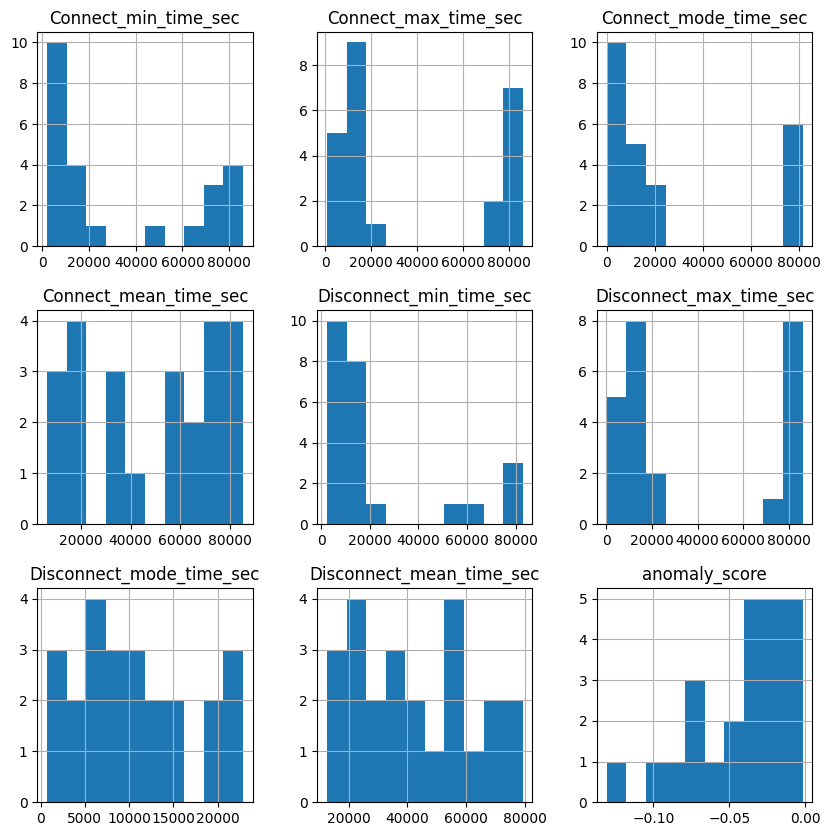

In [25]:
df_device_full_outliers.head()

fig = plt.figure(figsize=(10,10))
ax = fig.gca()

df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_device_file = df_device_full_outliers.loc[df_device_full_outliers['anomaly_score'] <= 0]
print(df_threat_users_device_file)

df_device_full[df_device_full.User.isin(df_threat_users_device_file.User)]

/Users/aimee/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


              user  unique_pc_count  anomaly_score
0     DTAA/AAA0371                4      -0.039566
10    DTAA/AAS0709                6      -0.063299
86    DTAA/AFH0331                6      -0.063299
94    DTAA/AFO0022                8      -0.041107
129   DTAA/AJA0220                4      -0.039566
...            ...              ...            ...
7630  DTAA/ULB0178                6      -0.063299
7636  DTAA/UMB0449                5      -0.061392
7673  DTAA/VFP0669               24      -0.005873
7754  DTAA/WFL0495                6      -0.063299
7854  DTAA/YVF0045               27      -0.024348

[147 rows x 3 columns]


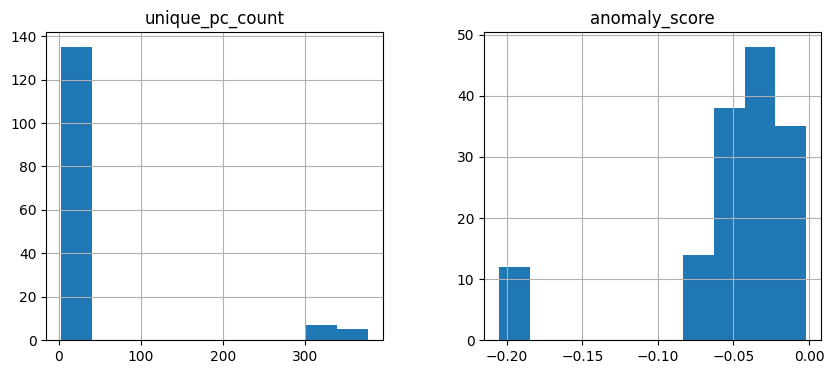

In [26]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()

df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] < 0].hist(ax=ax)

df_threat_users_unique_pc = df_unique_pc_outliers.loc[df_unique_pc_outliers['anomaly_score'] <= 0]
print(df_threat_users_unique_pc)